In [1]:
%run ./resources/library.py

In [2]:
style_notebook()

# Notebook 5 - Advanced: Drawing an Isochrone Map with OSMnx for Soho District in London

## Learning Objectives

By the end of this notebook, you should be able to:

1. Define an isochrone map
2. Recall the Python packages used in creating isochrone maps with osmnx
3. Describe the goal of map projections
4. Explain how an isochrone map helps identify which pump in Soho District appears to contribute to the cholera deaths based on walkability assumptions

## What is an Isochrone Map?

Isochrone maps are also known as travel time maps, from the Greek, "isos" (equal) + "khronos" (time). By drawing an isochrone map of Soho District based on the OSMnx street network graph, we can help Dr. John Snow visualize how far Soho District residents can walk given 1, 5, 10 or 15 minutes from the Broad Street Pump. 

In [3]:
import osmnx as ox, networkx as nx, geopandas as gpd, matplotlib.pyplot as plt
from shapely.geometry import Point, LineString, Polygon
from descartes import PolygonPatch

# some configuration parameters for osmnx
# set log to True to for debugging
ox.config(log_file=True, log_console=True, use_cache=True)

ox.__version__

'0.10'

We are using several Python packages for this notebook (the ones we have used are in <font color='red'>red</font>, links are provided for new ones):
1. <font color='red'>OSMnx</font>
2. <font color='red'>NetworkX</font>
3. <font color='red'>Pandas</font>
4. [GeoPandas](https://github.com/geopandas/geopandas)
5. <font color='red'>Matplotlib</font>
6. [Shapely](https://github.com/Toblerity/Shapely)
7. [Descartes](https://bitbucket.org/sgillies/descartes)

## Configuration variables

In [4]:
# configure the place, network type, trip times, and travel speed
BROAD_STREET_PUMP_COORDINATES = (51.513341, -0.136668)

network_type = 'walk' # osmnx has different network types
trip_times = [1, 5, 10, 15] # in minutes
travel_speed = 4.5 # walking speed in km/hour

#crs = {'init': 'epsg:4326'}

## Download and prep the street network

Let's obtain the street network graph for Soho District based on the coordinates of the Broad Street Pump.

In [5]:
# download the street network
G = ox.graph_from_point(BROAD_STREET_PUMP_COORDINATES, network_type=network_type)

In [6]:
# find the centermost node
gdf_nodes = ox.graph_to_gdfs(G, edges=False)
center_node = ox.get_nearest_node(G, BROAD_STREET_PUMP_COORDINATES)

center_node

25473293

In [7]:
gdf_nodes.head()

,highway,osmid,ref,x,y,geometry
2622783492,NaN,2622783492,NaN,-0.137756,51.507339,POINT (-0.1377558 51.5073392)
2622783496,NaN,2622783496,NaN,-0.137457,51.507440,POINT (-0.1374573 51.5074399)
2214952978,NaN,2214952978,NaN,-0.136643,51.509050,POINT (-0.1366425 51.5090502)
2214952980,crossing,2214952980,NaN,-0.137152,51.508879,POINT (-0.1371522 51.5088794)
2214952982,crossing,2214952982,NaN,-0.138650,51.508507,POINT (-0.1386498 51.5085071)


In [8]:
wgs84_crs = gdf_nodes.crs

wgs84_crs

'+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs'

We then project the map using a Universal Transverse Mercator (UTM) projection. Read more about UTM [here](https://gisgeography.com/utm-universal-transverse-mercator-projection/). `osmnx` uses UTM as a default projection.

In [9]:
G = ox.project_graph(G)

Let's save the graph as a shapefile. The shapefile is created with the specified `filename` in the `folder` as named below.

In [10]:
gdf_nodes = ox.graph_to_gdfs(G, edges=False)

utm_crs = gdf_nodes.crs

utm_crs

'+proj=utm +zone=30 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'

In [11]:
gdf_nodes.head()

,highway,lat,lon,osmid,ref,x,y,geometry
2622783492,NaN,51.507339,-0.137756,2622783492,NaN,698625.745934,5.710130e+06,POINT (698625.7459343299 5710129.920344741)
2622783496,NaN,51.507440,-0.137457,2622783496,NaN,698646.018323,5.710142e+06,POINT (698646.0183231209 5710141.926892565)
2214952978,NaN,51.509050,-0.136643,2214952978,NaN,698695.541804,5.710323e+06,POINT (698695.5418044265 5710323.176472939)
2214952980,crossing,51.508879,-0.137152,2214952980,NaN,698660.922364,5.710303e+06,POINT (698660.9223644909 5710302.802266562)
2214952982,crossing,51.508507,-0.138650,2214952982,NaN,698558.638543,5.710257e+06,POINT (698558.638542673 5710257.343245155)


In [12]:
ox.save_graph_shapefile(G, filename='graph', folder='outputs')

There is a 6-minute video below about map projections.

In [13]:
show_youtube("https://www.youtube.com/embed/kIID5FDi2JQ",900,600)

Going back to the concept of nodes and edges in a graph, we add an edge attribute that allows us to compute time in minutes required to traverse each edge (street) given number of minutes.

In [14]:
# add an edge attribute for time in minutes required to traverse each edge
meters_per_minute = travel_speed * 1000 / 60 #km per hour to m per minute
for u, v, k, data in G.edges(data=True, keys=True):
    data['time'] = data['length'] / meters_per_minute


## Plots nodes you can reach on foot within each time interval

How far can you walk in 1, 5, 10, and 15 minutes from the origin node? We'll use NetworkX to induce a subgraph of G within each distance, based on trip time and travel speed.

Recall we defined __trip time__ and __travel speed__ earlier (top of the notebook).
> `trip_times = [1, 5, 10, 15] #in minutes`  
> `travel_speed = 4.5 #walking speed in km/hour`

In [15]:
# get one color for each isochrone
iso_colors = ox.get_colors(n=len(trip_times), cmap='Reds', start=0.3, return_hex=True)


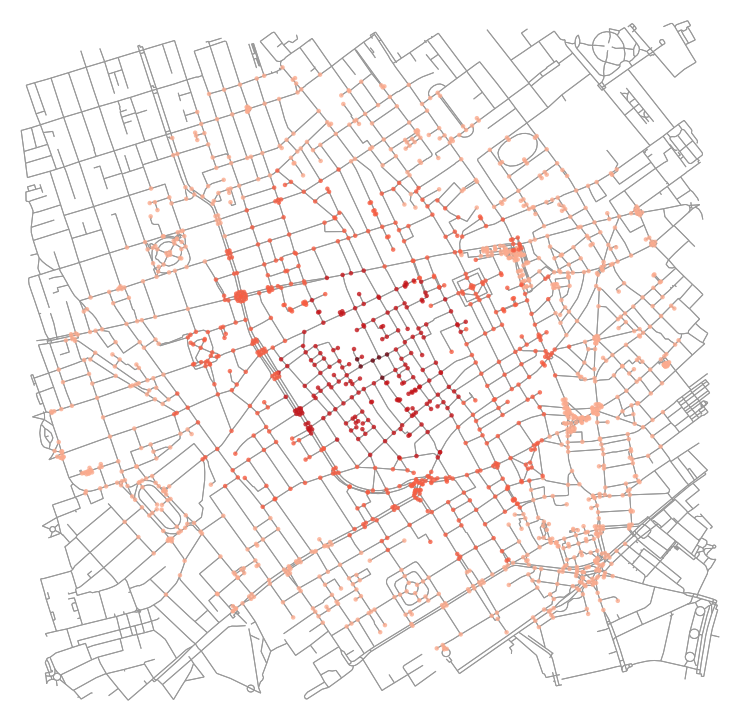

In [16]:
# color the nodes according to isochrone then plot the street network
node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')
    for node in subgraph.nodes():
        node_colors[node] = color
nc = [node_colors[node] if node in node_colors else 'none' for node in G.nodes()]
ns = [20 if node in node_colors else 0 for node in G.nodes()]
fig, ax = ox.plot_graph(G, fig_height=13, node_color=nc, \
                        node_size=ns, node_alpha=0.8, node_zorder=2)


## Plot the time-distances as isochrones

How far can you walk in 1, 5, 10, and 15 minutes from the origin node? To draw the isochrones, we'll use a convex hull. 

In [17]:
# create the isochrone polygons
isochrone_polys = []
for trip_time in sorted(trip_times, reverse=True):
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')
    node_points = [Point((data['x'], data['y'])) for node, data \
                   in subgraph.nodes(data=True)]
    bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
    isochrone_polys.append(bounding_poly)


Translating the `for` loop code above to natural language looks like this:

> <font color='blue'>For every trip time, starting from the biggest value (15 minutes):
1. Generate a subgraph from center node (the centroid obtained from previous code above)
2. Isolate all the points from subgraph
3. Generate the bounding polygons using convex hull method
4. Append the bounding polygons to a final set of isochrone polygons</font>

Printing `isochrone_polys` below shows it's a set of Shapely polygons.

In [18]:
isochrone_polys

Here is a short silent video about convex hulls (Quickhull method).

In [19]:
show_youtube("https://www.youtube.com/embed/3fQt5-JgNz0",900,600)

We then add each polygon to a plot of the street network graph. The `PolygonPatch()` function is from the `descartes` package. From the `descartes` link above, `descartes` enables you to "use Shapely or GeoJSON-like geometric objects as matplotlib paths and patches".

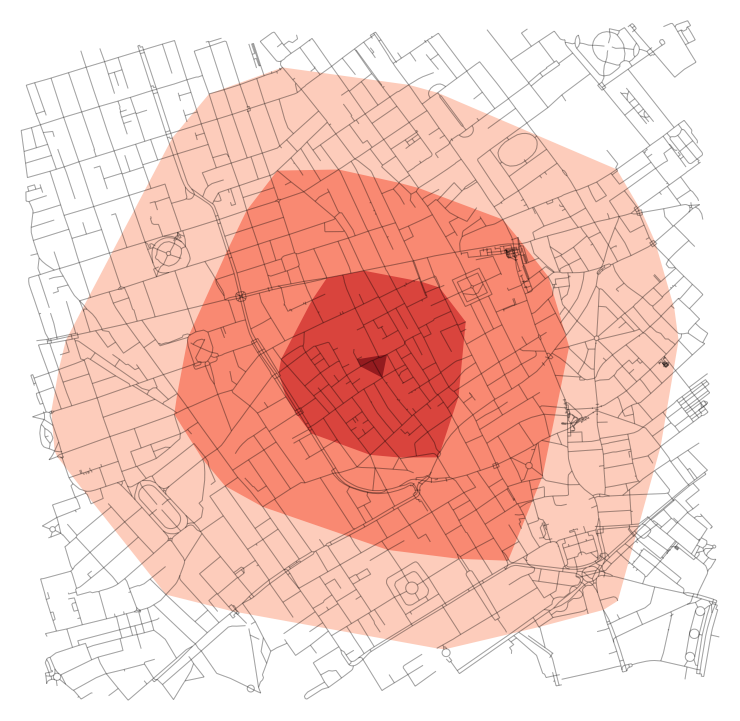

In [20]:
# plot the network then add isochrones as colored descartes polygon patches
fig, ax = ox.plot_graph(G, fig_height=13, show=False, \
                        close=False, edge_color='k', \
                        edge_alpha=0.2, node_color='none')

for polygon, fc in zip(isochrone_polys, iso_colors):
    patch = PolygonPatch(polygon, fc=fc, ec='none', alpha=0.6, zorder=-1)
    ax.add_patch(patch)
    
plt.show()


In [21]:
patch

## Or, plot isochrones as buffers to get more faithful isochrones than convex hulls can offer

We will use the Python function `make_iso_polys()` below 
to create isochrone polygons as buffers. 

In [22]:
def make_iso_polys(G, edge_buff=25, node_buff=50, infill=False, crs=utm_crs):
    isochrone_polys = []
    for trip_time in sorted(trip_times, reverse=True):
        subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')
        node_points = []
        for node, data in subgraph.nodes(data=True):
            #print(data['x'], data['y'])
            node_points.append(Point((data['x'], data['y'])))
        #node_points = [Point((data['x'], data['y'])) \
        #               for node, data in subgraph.nodes(data=True)]
        #[print(Point((data['x'], data['y']))) \
        #               for node, data in subgraph.nodes(data=True)]
        #[print(Point((x[0], y[0]))) \
        #               for node, data in subgraph.nodes(data=True)]
        nodes_gdf = gpd.GeoDataFrame({'id': subgraph.nodes()}, geometry=node_points)
        nodes_gdf = nodes_gdf.set_index('id')

        edge_lines = []
        for n_fr, n_to in subgraph.edges():
            f = nodes_gdf.loc[n_fr].geometry
            t = nodes_gdf.loc[n_to].geometry
            edge_lines.append(LineString([f,t]))

        n = nodes_gdf.buffer(node_buff).geometry
        e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
        all_gs = list(n) + list(e)
        new_iso = gpd.GeoSeries(all_gs).unary_union
        
        # try to fill in surrounded areas so shapes will appear 
        #    solid and blocks without white space inside them
        if infill:
            new_iso = Polygon(new_iso.exterior)
        isochrone_polys.append(new_iso)
    return isochrone_polys


We will then use this function in the code below and add the isochrone polygons to the a plot of the street network graph.

In [23]:
isochrone_polys = make_iso_polys(G, edge_buff=25, node_buff=0, infill=True)

isochrone_polys

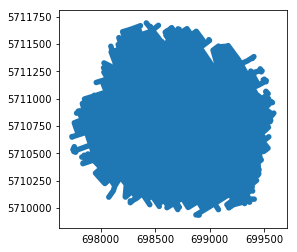

In [24]:
poly_gdf_15 =  gpd.GeoDataFrame(index=[0], geometry=[isochrone_polys[0]], crs=utm_crs)
poly_gdf_15.plot()

In [25]:
poly_gdf_15.to_file(driver = 'ESRI Shapefile', filename="outputs/poly15.shp")
!ls -la outputs

total 4392
drwxr-xr-x  3 jovyan users    4096 Jul 30 09:38 .
drwxr-xr-x 10 jovyan users    4096 Jul 30 09:36 ..
-rw-r--r--  1 jovyan users      10 Jul 30 09:23 deaths.cpg
-rw-r--r--  1 jovyan users   21412 Jul 30 09:23 deaths.dbf
-rw-r--r--  1 jovyan users   14878 Jun 27 12:16 deaths_df.pickle
-rw-r--r--  1 jovyan users   13131 Jun 27 12:16 deaths_mean_center_df.pickle
-rw-r--r--  1 jovyan users     389 Jul 30 09:23 deaths.prj
-rw-r--r--  1 jovyan users    7100 Jul 30 09:23 deaths.shp
-rw-r--r--  1 jovyan users    2100 Jul 30 09:23 deaths.shx
drwxr-xr-x  4 jovyan users    4096 Jun 27 12:16 graph
-rw-r--r--  1 jovyan users 2419236 Jul 25 15:18 graph.html
-rw-r--r--  1 jovyan users     715 Jun 27 12:16 mean_center_df.pickle
-rw-r--r--  1 jovyan users      10 Jul 30 09:38 poly15.cpg
-rw-r--r--  1 jovyan users      78 Jul 30 09:38 poly15.dbf
-rw-r--r--  1 jovyan users     389 Jul 30 09:38 poly15.prj
-rw-r--r--  1 jovyan users   76588 Jul 30 09:38 poly15.shp
-rw-r--r--  1 jovyan users     1

In [26]:
import pandas as pd

deaths_df = pd.read_csv('resources/cholera_deaths.csv')

deaths_df.head()

,FID,DEATHS,LON,LAT
0,0,3,-0.137930,51.513418
1,1,2,-0.137883,51.513361
2,2,1,-0.137853,51.513317
3,3,1,-0.137812,51.513262
4,4,4,-0.137767,51.513204


In [27]:
pumps_df = pd.read_csv('resources/pumps.csv')

pumps_df.head()

,FID,LON,LAT,Street
0,250,-0.136668,51.513341,Broadwick Street
1,251,-0.139586,51.513876,Kingly Street
2,252,-0.139671,51.514906,Ramillies Place
3,253,-0.131630,51.512354,Dean Street
4,254,-0.133594,51.512139,Rupert Street


In [28]:
utm_crs

'+proj=utm +zone=30 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'

In [29]:
deaths_gdf = \
    gpd.GeoDataFrame(\
                     deaths_df, \
                     geometry=gpd.points_from_xy(deaths_df.LON, deaths_df.LAT), \
                     crs=wgs84_crs)

deaths_gdf.crs

'+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs'

In [30]:
deaths_gdf.to_file('outputs/deaths.shp')

deaths_gdf = gpd.read_file('outputs/deaths.shp').to_crs(utm_crs)

deaths_gdf

,FID,DEATHS,LON,LAT,geometry
0,0,3,-0.137930,51.513418,POINT (698587.2123106787 5710805.302450837)
1,1,2,-0.137883,51.513361,POINT (698590.7208421305 5710799.092652294)
2,2,1,-0.137853,51.513317,POINT (698592.9934763478 5710794.28207391)
3,3,1,-0.137812,51.513262,POINT (698596.0770804603 5710788.278354387)
4,4,4,-0.137767,51.513204,POINT (698599.4512374601 5710781.951949307)
5,5,2,-0.137537,51.513184,POINT (698615.4941019658 5710780.352764181)
6,6,2,-0.138200,51.513359,POINT (698568.7383150364 5710798.009734619)
7,7,2,-0.138045,51.513328,POINT (698579.6259973894 5710794.983844632)
8,8,3,-0.138276,51.513323,POINT (698563.6225837551 5710793.800868109)
9,9,2,-0.138223,51.513427,POINT (698566.8469045842 5710805.507701557)


In [31]:
pumps_gdf = \
    gpd.GeoDataFrame(\
                     pumps_df, \
                     geometry=gpd.points_from_xy(pumps_df.LON, pumps_df.LAT), \
                     crs=wgs84_crs)

pumps_gdf.crs

'+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs'

In [32]:
pumps_gdf.to_file('outputs/pumps.shp')

pumps_gdf = gpd.read_file('outputs/pumps.shp').to_crs(utm_crs)

pumps_gdf

,FID,LON,LAT,Street,geometry
0,250,-0.136668,51.513341,Broadwick Street,POINT (698675.0960317799 5710800.168223312)
1,251,-0.139586,51.513876,Kingly Street,POINT (698470.3392431232 5710851.729611232)
2,252,-0.139671,51.514906,Ramillies Place,POINT (698459.9638248486 5710966.016875976)
3,253,-0.131630,51.512354,Dean Street,POINT (699028.9006750595 5710704.126551507)
4,254,-0.133594,51.512139,Rupert Street,POINT (698893.5861703848 5710674.880571264)
5,255,-0.135919,51.511542,Bridle Lane,POINT (698734.8890904885 5710602.185801377)
6,256,-0.133962,51.510019,Regent Street,POINT (698877.292712635 5710438.173724256)
7,257,-0.138199,51.511295,Warwick Street,POINT (698577.7870086415 5710568.53208039)


## Bring the plots together

In [33]:
def label_point(x, y, val, ax, fs):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+20, point['y']+10, str(point['val']), fontsize=fs)

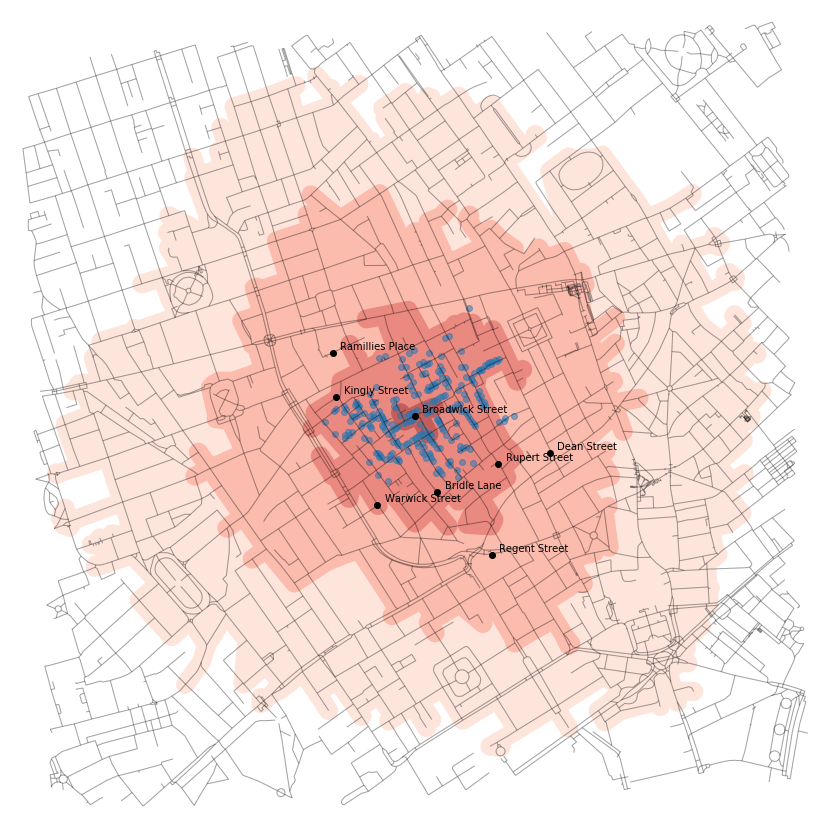

In [34]:
fig, ax = ox.plot_graph(G, fig_height=15, show=False, \
                        close=False, edge_color='k', \
                        edge_alpha=0.2, node_color='none')
for polygon, fc in zip(isochrone_polys, iso_colors):
    patch = PolygonPatch(polygon, fc=fc, ec='none', alpha=0.3, zorder=-1)
    ax.add_patch(patch)

deaths_gdf.plot(ax=ax, alpha=0.5)
pumps_gdf.plot(ax=ax, color='black')

pumps_gdf['LON'] = pumps_gdf.geometry.x
pumps_gdf['LAT'] = pumps_gdf.geometry.y
label_point(pumps_gdf['LON'], pumps_gdf['LAT'], pumps_gdf.Street, ax, 10)

plt.show()

## References

1. Further Exploration #9: Isochrone Maps (Travel Time Maps). URL: http://datavizcatalogue.com/blog/isochrone-maps/
2. Boeing, G. Isochrone Maps with OSMnx + Python. URL: https://geoffboeing.com/2017/08/isochrone-maps-osmnx-python/
3. MapBox Isochrone Maps. URL: https://www.mapbox.com/bites/00156
4. https://en.wikipedia.org/wiki/Decimal_degrees


*For case study suggestions for improvement, please contact Herman Tolentino, Jan MacGregor, James Tobias or Zhanar Haimovich.*